In [1]:



%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

from manuscript import iterate_subsamples_over_notebooks

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")

In [3]:
import matplotlib.pyplot as plt

In [4]:
in_user = 'general'     # defines top hierarchy of input folder
in_mainstem = '40_iterate_after_subsampling_patients'    


out_user = 'general'     # defines top hierarchy of output folder
outfolder = '42_analyze_after_subsampling_patients_with_respiratory_score'    # name of notebook
save = False

In [5]:
def dump_figure(name):
    if save:
        export.image(
            out_user,
            f'{outfolder}/{name}',
        )

In [6]:
def dump_table(df, name):
    if save:
        export.full_frame(
            out_user, 
            f'{outfolder}/{name}', 
            df, 
            index=True,
            date=False
        )

In [7]:
failed = []

In [8]:
def get_stats(subpath):
    agg = []

    for boot in ['all'] + [int(x) for x in range(1, 501)]:
    # for boot in [int(x) for x in range(200, 232)]:

        if boot != 'all':
            boot = f'{boot}'.zfill(4)


        outstem = f'{in_mainstem}/{boot}/'


        p = inout.get_material_path(
            os.path.join(in_user, outstem, subpath)
        ) #  outstemaa
        
        if p.endswith('.xlsx'):
            df = pd.read_excel(p)
        elif p.endswith('.csv'):
            df = pd.read_csv(p)
            
        df.loc[:, 'boot'] = boot
        agg.append(df)
        
    df = pd.concat(agg)
    return df
#    

In [9]:
df = get_stats('06_covid-analysis/n-days-per-cluster_stats.xlsx')

In [10]:
df['significant'] = df['pval_adj'] < 0.05
df['longer_in_covid'] = df['group2_median'] > df['group1_median']

In [11]:
df[df['boot']=='all'].sort_values(['significant', 'longer_in_covid'], ascending=False)

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot,significant,longer_in_covid
2,cluster,5,False,True,79,129,1.264980e-04,1.0,3.0,0.000354,all,True,True
4,cluster,10,False,True,132,115,3.983523e-07,2.0,3.0,0.000002,all,True,True
5,cluster,11,False,True,47,51,1.099036e-05,2.0,15.0,0.000038,all,True,True
6,cluster,1,False,True,115,89,1.624799e-07,2.0,4.0,0.000002,all,True,True
9,cluster,13,False,True,35,80,5.631732e-03,2.0,4.0,0.011263,all,True,True
12,cluster,2,False,True,83,52,4.271449e-07,2.0,8.0,0.000002,all,True,True
0,cluster,3,False,True,168,58,2.834774e-03,3.0,2.0,0.006614,all,True,False
3,cluster,6,False,True,47,75,2.950588e-02,2.0,4.0,0.051635,all,False,True
11,cluster,14,False,True,130,34,4.353034e-01,2.0,2.5,0.468788,all,False,True
13,cluster,12,False,True,14,16,2.670864e-01,5.0,11.0,0.311601,all,False,True


In [12]:
df = df[df['boot']!='all'].copy()

In [13]:
if not df[df['significant']]['boot'].nunique() == df['boot'].nunique():
    raise AssertionError('at least one iteration did not have any significant differnce')

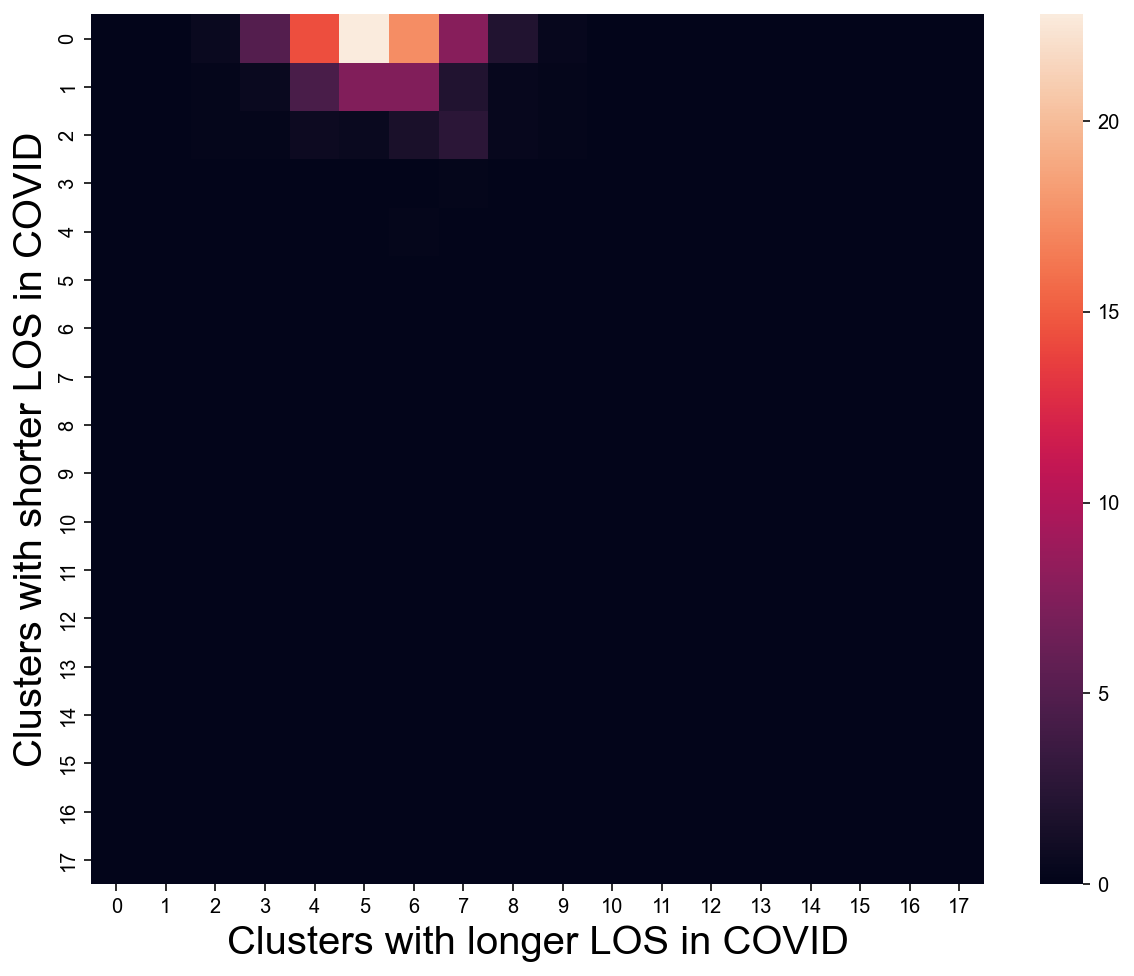

In [14]:
sns.heatmap(
    df[df['significant']].groupby(['boot', 'longer_in_covid']).size().to_frame('c').reset_index().pivot(
        index='boot', columns='longer_in_covid', values='c'
    ).fillna(0).groupby([False, True]).size().to_frame('tot').reset_index().pivot(
        index=False, columns=True, values='tot').fillna(0).reindex(index=range(0, 18), columns=range(0, 18)).fillna(0) / 5
)

plt.xlabel('Clusters with longer LOS in COVID', fontsize=20)
plt.ylabel('Clusters with shorter LOS in COVID', fontsize=20)
dump_figure('absolute_clusters.pdf')

In [15]:
df

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot,significant,longer_in_covid
0,cluster,1,False,True,43,38,4.972036e-04,2.0,6.5,1.740213e-03,0001,True,True
1,cluster,3,False,True,177,99,7.648643e-02,2.0,3.0,1.273530e-01,0001,False,True
2,cluster,4,False,True,91,87,8.496074e-06,2.0,4.0,5.947252e-05,0001,True,True
3,cluster,13,False,True,82,111,1.389403e-08,2.0,5.0,1.945164e-07,0001,True,True
4,cluster,12,False,True,18,36,2.758727e-02,3.5,13.5,6.437029e-02,0001,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,cluster,10,False,True,111,24,7.998282e-02,2.0,3.5,1.599656e-01,0500,False,True
10,cluster,6,False,True,11,38,4.619659e-01,3.0,5.5,5.442979e-01,0500,False,True
11,cluster,9,False,True,189,36,2.400202e-01,3.0,2.0,3.733647e-01,0500,False,False
12,cluster,5,False,True,104,20,6.252399e-02,2.5,3.5,1.458893e-01,0500,False,True


In [16]:
helper = df[df['significant']].groupby('boot')['longer_in_covid'].mean().to_frame('share')

In [17]:
f = helper['share'] < 0.5
helper.loc[f, 'kind'] = 'mostly shorter in COVID'

f = helper['share'] > 0.5
helper.loc[f, 'kind'] = 'mostly longer in COVID'

f = helper['share'] == 0
helper.loc[f, 'kind'] = 'always shorter in COVID'

f = helper['share'] == 1
helper.loc[f, 'kind'] = 'always longer in COVID'

f = helper['share'] == 0.5
helper.loc[f, 'kind'] = 'equal in COVID'

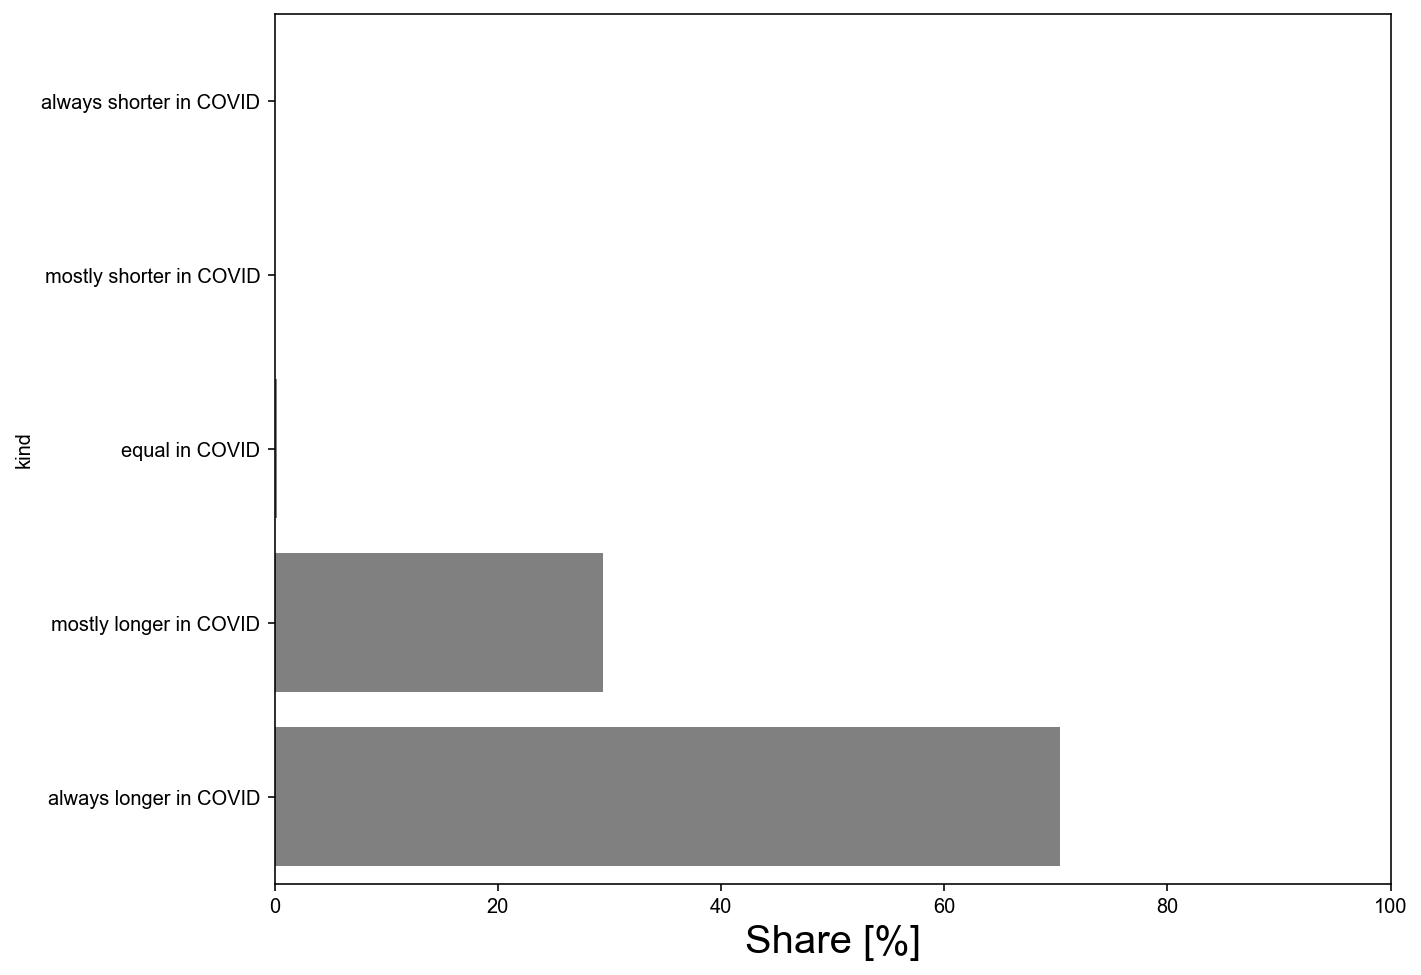

In [18]:
sns.barplot(
    y='kind',
    x='share',
    estimator=lambda x: 100*(len(x)/helper.shape[0]),
    data=helper,
    order=[
        'always shorter in COVID',
        'mostly shorter in COVID',
        'equal in COVID',
        'mostly longer in COVID',
        'always longer in COVID',        
    ],
    color='grey'
)

plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)

dump_figure('normalized_duration.pdf')

In [19]:
d = get_stats('04x_spider_trimmed/quiltdf3_normalized_then_relative_respiratory_score.csv')

In [20]:
h = pd.merge(
    df,
    d.rename(columns={'index': 'value'})


)

In [21]:
h['group'] = h['longer_in_covid'].copy().replace({True: 'significantly longer', False: 'significantly shorter'})
f = h['significant'] == False
h.loc[f, 'group'] = 'ns'

In [22]:
helper

,share,kind
boot,,
0001,0.800000,mostly longer in COVID
0002,0.857143,mostly longer in COVID
0003,1.000000,always longer in COVID
0004,0.800000,mostly longer in COVID
0005,1.000000,always longer in COVID
...,...,...
0496,1.000000,always longer in COVID
0497,0.750000,mostly longer in COVID
0498,0.857143,mostly longer in COVID


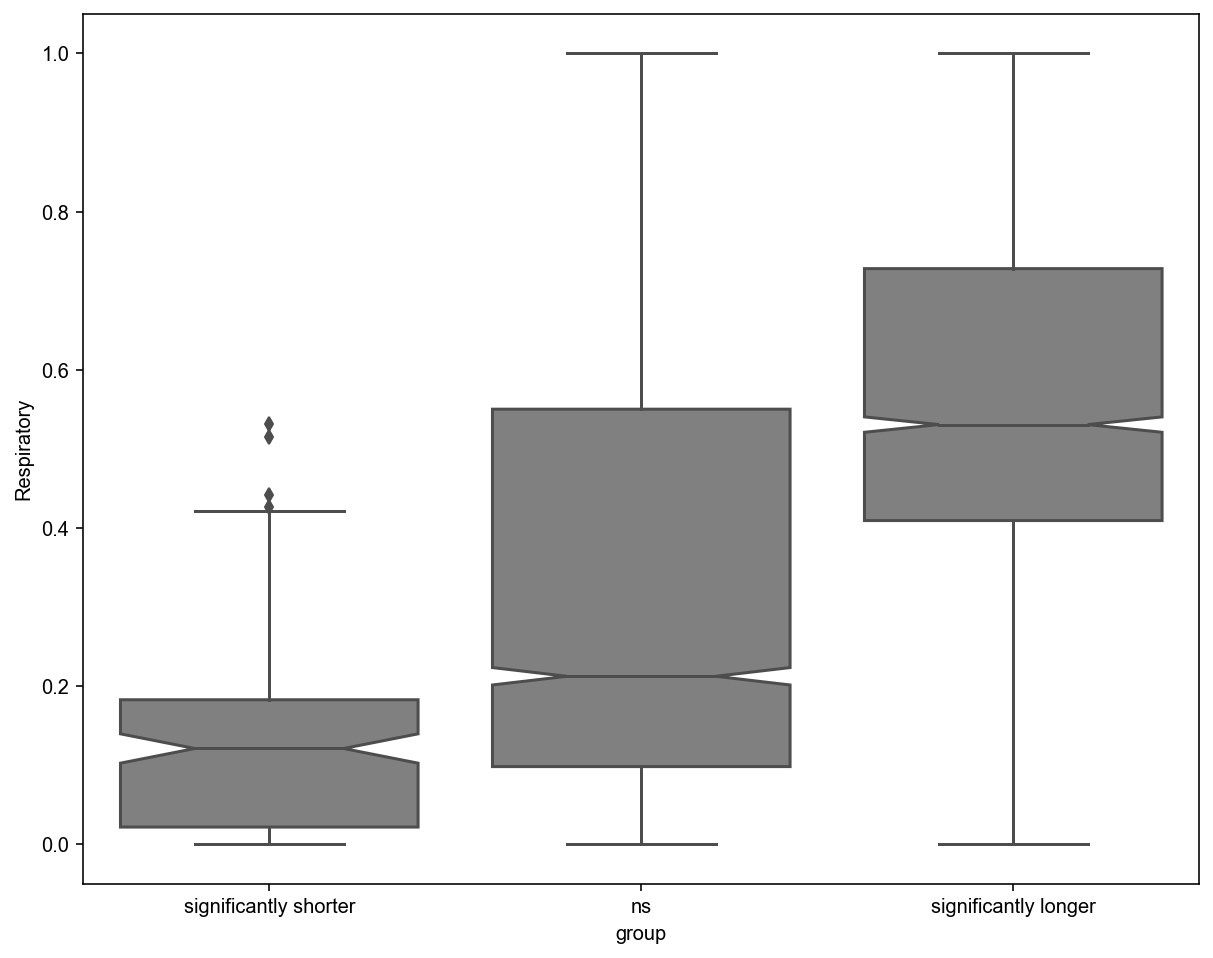

In [23]:
sns.boxplot(
    x='group',
    y='Respiratory',
    data=h,
    notch=True,
    order=['significantly shorter', 'ns', 'significantly longer'],
    color='grey'


)


dump_figure('pool_over_all_iterations_and_clusters.pdf')


In [34]:
from scipy.stats import mannwhitneyu

In [39]:
h[h['group']=='significantly shorter']['Respiratory']

5       0.120537
17      0.213661
50      0.021940
206     0.000000
234     0.072044
          ...   
6884    0.034922
6894    0.001457
6943    0.123954
6951    0.000000
6963    0.000000
Name: Respiratory, Length: 186, dtype: float64

In [41]:
mannwhitneyu(
    h[h['group']=='significantly shorter']['Respiratory'],
    h[h['group']=='ns']['Respiratory'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=232035.0, pvalue=1.6984332708748013e-20)

In [42]:
mannwhitneyu(
    h[h['group']=='significantly longer']['Respiratory'],
    h[h['group']=='ns']['Respiratory'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=8458818.5, pvalue=1.3512174733131683e-303)

In [24]:
h['of_interest'] = h['group'] == 'significantly longer'

In [25]:
c = h.groupby(['boot', 'of_interest'])['Respiratory'].median().to_frame('Respiratory').reset_index().pivot(
    index='boot', columns='of_interest', values='Respiratory')

In [26]:
h

,variable,value,group1,group2,group1_size,group2_size,pval,group1_median,group2_median,pval_adj,boot,significant,longer_in_covid,Unnamed: 0,Neurologic,Respiratory,Shock,Renal,Inflammatory,Ventilator instability,Relative Resp Severity,group,of_interest
0,cluster,1,False,True,43,38,4.972036e-04,2.0,6.5,1.740213e-03,0001,True,True,0,0.276889,0.457426,0.195432,0.225389,0.693498,0.000000,0.247440,significantly longer,True
1,cluster,3,False,True,177,99,7.648643e-02,2.0,3.0,1.273530e-01,0001,False,True,2,0.000000,0.185589,0.000000,0.377773,0.255297,0.216829,0.388627,ns,False
2,cluster,4,False,True,91,87,8.496074e-06,2.0,4.0,5.947252e-05,0001,True,True,3,0.677177,0.365790,0.274324,0.365503,0.483108,0.665709,0.364280,significantly longer,True
3,cluster,13,False,True,82,111,1.389403e-08,2.0,5.0,1.945164e-07,0001,True,True,12,1.000000,0.763653,0.856794,0.442789,1.000000,0.427871,0.265307,significantly longer,True
4,cluster,12,False,True,18,36,2.758727e-02,3.5,13.5,6.437029e-02,0001,False,True,11,0.759359,1.000000,0.683078,0.390718,0.771058,0.460976,0.359387,ns,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6994,cluster,10,False,True,111,24,7.998282e-02,2.0,3.5,1.599656e-01,0500,False,True,9,0.305672,0.222757,0.774737,0.759774,0.688963,0.026236,0.089626,ns,False
6995,cluster,6,False,True,11,38,4.619659e-01,3.0,5.5,5.442979e-01,0500,False,True,5,0.946861,0.764863,0.618374,0.059098,0.916362,0.145884,0.263874,ns,False
6996,cluster,9,False,True,189,36,2.400202e-01,3.0,2.0,3.733647e-01,0500,False,False,8,0.697100,0.000000,0.811065,0.798513,0.658017,0.251507,0.078200,ns,False
6997,cluster,5,False,True,104,20,6.252399e-02,2.5,3.5,1.458893e-01,0500,False,True,4,0.471002,0.091556,0.169086,0.626271,0.658255,0.177342,0.122588,ns,False


In [27]:
(c[True] > c[False]).sum()

497

In [28]:
f = c[True] > c[False]

In [29]:
c.loc[f, 'kind'] = 'elevated'
c.loc[~f, 'kind'] = 'not elevated'

In [30]:
c.loc[:, 'dummy'] = 1

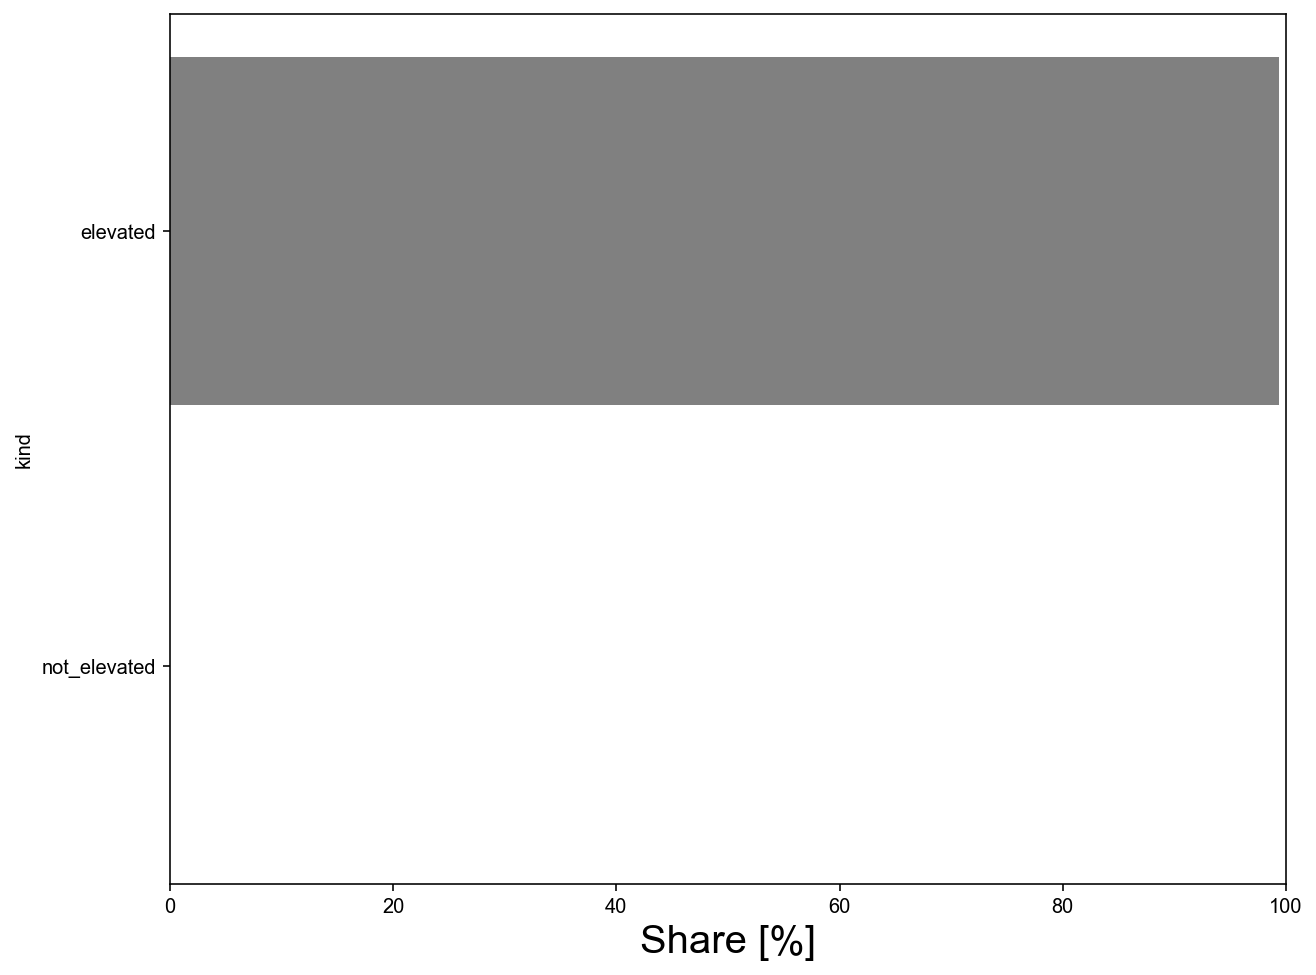

In [31]:
sns.barplot(y='kind', x='dummy', data=c, estimator=lambda x: 100*sum(x)/c.shape[0],
           color='grey', order=['elevated', 'not_elevated']
           
           )


plt.xlim(0, 100)
plt.xlabel('Share [%]', fontsize=20)


dump_figure('median_over_all_iterations.pdf')

In [32]:
c['kind'].value_counts()

elevated        497
not elevated      3
Name: kind, dtype: int64